# Deloitte Quantum Challenge 2023

# =============================

# 0. References and credits

'''
Team: Quantux
Members: ...

V00 20230317 - Phase 1: Establishment
V01 20230226 - Phase 1: Add various local & realtime VQE client
V02 20230301 - Phase 1: Add decorators and modularise pipeline
'''

'''
References:
# Python functions
https://dev.to/kcdchennai/python-decorator-to-measure-execution-time-54hk

# Machine Learning modules
https://towardsdatascience.com/state-of-the-art-machine-learning-hyperparameter-optimization-with-optuna-a315d8564de1

# Qiskit with latest post-migration modules and functions
https://github.com/PacktPublishing/Quantum-Chemistry-and-Computing-for-the-Curious/blob/main/Chapter_05_Variational_Quantum_Eigensolver_.VQE._algorithm_V2.ipynb

https://qiskit.org/documentation/nature/_modules/qiskit_nature/second_q/
https://qiskit.org/documentation/nature/migration/00b_Electronic_structure_with_v0.5.html
https://qiskit.org/documentation/nature/tutorials/03_ground_state_solvers.html
https://qiskit.org/documentation/nature/tutorials/05_problem_transformers.html

# Qiskit realtime IBQM providers
https://qiskit.org/documentation/stubs/qiskit.providers.ibmq.AccountProvider.html
https://qiskit.org/documentation/partners/qiskit_ibm_provider/tutorials/Migration_Guide_from_qiskit-ibmq-provider.html

'''

# =============================

# 1. Import libraries and qiskit functions

In [1]:
# 0. Data science & ML libraries
# =============================
import pandas as pd
import numpy as np
import warnings, os, time
import matplotlib.pyplot as plt
from tqdm import tqdm

warnings.filterwarnings('ignore')

from functools import wraps
from qiskit.utils import algorithm_globals

from functools import partial
from scipy.optimize import minimize

_SEED = 5
np.random.seed(_SEED)
algorithm_globals.random_seed = _SEED

In [25]:
# All are post-migration imports, ie. qiskit_nature == 0.5.0
import qiskit, qiskit_nature
v_qiskit = qiskit.__version__
v_qiskit_nature = qiskit_nature.__version__

if (v_qiskit >= '0.22') and (v_qiskit_nature >= '0.5'):
    
    # 1. Load for runtime qiskit
    # =============================
    from qiskit import IBMQ
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='deloitte-event23', group='level-1-access', project='quantux')
    # provider.backends() # List all backend providers
    qasm_simulator = provider.get_backend('ibmq_qasm_simulator')
    statevector_simulator = provider.get_backend('simulator_statevector')
    from qiskit.providers.aer import StatevectorSimulator
    from qiskit import Aer

    # 2. Molecule & backend definition
    # =============================
    from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
    from qiskit_nature.units import DistanceUnit
    from qiskit.utils import QuantumInstance
    from qiskit_nature.second_q.drivers import PySCFDriver

    # VQE Client seem can't be used, use VQE instead
    # from qiskit_nature.runtime import VQEClient

    # 3. Estimators & Sampler Primitives
    # =============================
    from qiskit.primitives import Estimator, Sampler

    # 4. Ansatz, initial circuit libraries, initial points (Ansatz parameters)
    # =============================
    from qiskit_nature.second_q.circuit.library import UCC, UCCSD, PUCCD, SUCCD, UVCCSD # Ansatz
    from qiskit_nature.second_q.circuit.library import HartreeFock # Initial State
    from qiskit.circuit.library import TwoLocal, PauliTwoDesign, EfficientSU2, RealAmplitudes # Initial Circuit
    from qiskit.quantum_info import Pauli
    #from qiskit.circuit.library.initial_states import hartree_fock, fermionic_gaussian_state, vscf
    #from qiskit.circuit.library.initial_points import mp2_initial_point, hf_initial_point, mp2_initial_point, vscf_initial_point

    # 5. Qubit Mappers & transformers
    # =============================
    from qiskit_nature.second_q.mappers import JordanWignerMapper, QubitConverter, BravyiKitaevMapper, ParityMapper
    from qiskit_nature.second_q.transformers import ActiveSpaceTransformer, FreezeCoreTransformer

    # 6. Algorithms & optimizers
    # =============================
    from qiskit_nature.second_q.algorithms import NumPyMinimumEigensolverFactory, VQEUCCFactory, VQEUVCCFactory
    from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
    from qiskit_nature.second_q.algorithms.ground_state_solvers import GroundStateEigensolver
    from qiskit.algorithms.optimizers import COBYLA, SLSQP, SPSA, QNSPSA

    from qiskit.algorithms import HamiltonianPhaseEstimation, PhaseEstimation
    from qiskit.opflow import StateFn, PauliExpectation, CircuitSampler, PauliTrotterEvolution

else:
    print('Qiskit version not mostly updated - v2. Need updates before continue.')
    pass

ibmqfactory.load_account:WARNING:2023-03-08 15:18:59,879: Credentials are already in use. The existing account in the session will be replaced.


# =============================

# 2. Define construct problem modules

# 2-0. Decorators

In [26]:
# Timeit decorator
def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function {func.__name__} took {total_time:.4f} seconds to run\n')
        return result
    return timeit_wrapper


In [27]:
# Try except decorator
def get_err_msg(value):
    def decorate(f):
        def applicator(_silent = False, *args, **kwargs):
            try:
                if not _silent:
                    print('{}: Loading...'.format(f.__name__))
                
                res = f(*args,**kwargs)
                
                if not _silent:
                    print('Success in loading {}'.format(f.__name__))
                return res
                
            except:
                if not _silent:
                    print('Fail in loading {}'.format(f.__name__))
                return value
        return applicator
    return decorate

In [28]:
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator, Options)
from qiskit import Aer

# service = QiskitRuntimeService(channel='ibm_quantum')
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='deloitte-event23/level-1-access/quantux',
)

backend_real = 'ibmq_jakarta'

import signal, time

from qiskit.providers import JobStatus

def timeout_handler(signum, frame):
    raise Exception('Iteration timed out')

from qiskit.algorithms import MinimumEigensolver, VQEResult

# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None, init_data=[]):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        self._init_data = init_data
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            # Execute job with estimator primitive
            job = self._estimator.run([self._circuit], [operators], [x])
            print("EstimatorJob:", job.job_id())
            # Get results from jobs
            est_result = job.result()
            # Get the measured energy value
            value = est_result.values[0]
            print("Job Value:", job.job_id(), value)
            # Save result information using callback function
            if self._callback is not None:
                self._callback(value)
            return value
            
        # Select an initial point for the ansatzs' parameters
        if len(self._init_data) > 0:
            x0 = init_data
        else:
            x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result


class RetryEstimator(Estimator):
    """RuntimeRetryEstimator class.
    
    This class inherits from Qiskit IBM Runtime's Estimator and overwrites its run method such that it retries calling it
    a maximum of 'max_retries' consecutive times, if it encounters one of the following randomly occuring errors:
    
    * An Estimator error (in this case "Job.ERROR" is printed, and the job is cancelled automatically)
    * A timeout error where the job either remains running or completes but does not return anything, for a time larger 
      than 'timeout' (in this case the job is cancelled by the patch and "Job.CANCELLED" is printed)
    * A creation error, where the job fails to be created because connection is lost between the runtime server and the
      quantum computer (in this case "Failed to create job." is printed). If this error occurs, the patch connects the user
      to a new Session (to be handled with care! also, this will unfortunately put the next job in the queue). 
    """
    
    def __init__(self, *args, max_retries: int = 5, timeout: int = 3600, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.max_retries = max_retries
        self.timeout = timeout
        self.backend = super().session._backend
        signal.signal(signal.SIGALRM, timeout_handler)
    
    def run(self, circuits, observables, parameter_values, **kwargs):
        result = None
        for i in range(self.max_retries):
            try:
                job = super().run(circuits, observables, parameter_values, **kwargs)
                while job.status() in [JobStatus.INITIALIZING, JobStatus.QUEUED, JobStatus.VALIDATING]:
                    time.sleep(5) # Check every 5 seconds whether job status has changed
                signal.alarm(self.timeout) # Once job starts running, set timeout to 1 hour by default
                result = job.result()
                if result is not None:
                    signal.alarm(0) # reset timer
                    return job
            except Exception as e:
                print("\nSomething went wrong...")
                print(f"\n\nERROR MESSAGE:\n{e}\n\n")
                if 'job' in locals(): # Sometimes job fails to create
                    print(f"Job ID: {job.job_id}. Job status: {job.status()}.")
                    if job.status() not in [JobStatus.DONE, JobStatus.ERROR, JobStatus.CANCELLED]:
                        job.cancel()
                else:
                    print("Failed to create job.")
                print(f"Starting trial number {i+2}...\n")
                print(f"Creating new session...\n")
                signal.alarm(0) # reset timer
                super().session.close()
                self._session = Session(backend=self.backend)
        if result is None:
            raise RuntimeError(f"Program failed! Maximum number of retries ({self.max_retries}) exceeded")

intermediate_info_real_backend = []
def callback_real(value):
        intermediate_info_real_backend.append(value)

# 2-1. Define modular functions

In [6]:
# 1. Get problem driver
#@get_err_msg('')
#@timeit
def _1_get_problem_driver(display_dict, input_value, basis = 'sto3g', input_type = 'molecule'):
    
    # =============================
    # 1. Define Molecule dictionary and return problem from PySCFDriver
    # =============================
    
    # =============================
    if input_type == 'molecule':
        moleculeinfo = MoleculeInfo(symbols = input_value['symbols'], coords = input_value['coords'], masses = input_value['masses'], 
                                    charge = input_value['charge'], multiplicity = input_value['multiplicity'])
    
    elif input_type == 'moleculeinfo':
        moleculeinfo = input_value
    
    driver = PySCFDriver.from_molecule(moleculeinfo, basis=basis)
    problem = driver.run()
    
    
    if display_dict is not None:
        display_dict['molecule'] = '{}'.format(input_value['symbols'])
        display_dict['charge'] = '{}'.format(input_value['charge'])
        display_dict['multiplicity'] = '{}'.format(input_value['multiplicity'])
        
        display_dict['reference_energy'] = '{}'.format(problem.reference_energy)
        display_dict['num_spin_orbitals'] = '{}'.format(problem.num_spin_orbitals)
        display_dict['num_spatial_orbitals'] = '{}'.format(problem.num_spatial_orbitals)
        display_dict['num_particles'] = '{}'.format(problem.num_particles)
        display_dict['nuclear_repulsion_energy'] = '{}'.format(problem.nuclear_repulsion_energy)
        display_dict['num_alpha'] = '{}'.format(problem.num_alpha)
        display_dict['num_beta'] = '{}'.format(problem.num_beta)
        
        display_dict_new = display_dict
    else:
        display_dict_new = display_dict
    
    return problem, display_dict_new

In [7]:
# 1. Get transform problem
#@get_err_msg('')
#@timeit
def _2_get_problem_transform(display_dict, problem, input_value, reduced):
    
    # =============================
    # 2. Transform the problem to reduce simulation space
    # =============================
    
    # =============================
    # If enter gas_molecules info, can transform; else if enter molecularinfo info, can not transform (should have previously transformed)
    
    # Problem reduction
    if reduced == 'FreezeCore':
        try:
            fc_transformer = FreezeCoreTransformer(freeze_core = input_value['fc_transformer']['fc_freeze_core'], 
                                                   remove_orbitals = input_value['fc_transformer']['fc_remove_orbitals'])
            problem = fc_transformer.transform(problem)
            display_chosen = input_value['fc_transformer']['fc_remove_orbitals']
        except:
            #print('FreezeCore Transformer did not succeed.')
            if display_dict is not None:
                display_dict['FreezeCoreTransformer'] = 'error'
            pass
        
        # How to determine which orbitals to be removed
        # https://quantumcomputing.stackexchange.com/questions/17852/use-one-body-integrals-to-know-which-orbitals-to-freeze-in-electronicstructurepr
        # https://www.youtube.com/watch?v=3B04KB0pDwE&t=667s
        
    elif reduced == 'ActiveSpace':
        #max_num_spatial_orbitals = problem.num_spatial_orbitals
        #max_num_electrons = problem.num_electrons
        #max_active_orbitals = itertools.combinations(max_num_spatial_orbitals, 2)
        # Use optuna to setup objective
        
        try:
            as_transformer = ActiveSpaceTransformer(num_electrons = input_value['as_transformer']['as_num_electrons'], 
                                                    num_spatial_orbitals = input_value['as_transformer']['as_num_spatial_orbitals'], 
                                                    active_orbitals = input_value['as_transformer']['as_active_orbitals'])
            problem = as_transformer.transform(problem)
            display_chosen = input_value['as_transformer']['as_active_orbitals']
        except:
            #print('ActiveSpace Transformer did not succeed.')
            if display_dict is not None:
                display_dict['ActiveSpaceTransformer'] = 'error'
            pass
    else:
        # print('Expect lengthy simulation if can not succeed in reducing orbitals using FreezeCoreTransformer or ActiveSpaceTransformer.')
        display_chosen = ''
        pass
    
    
    if display_dict is not None:
        display_dict['reduction_method'] = '{}'.format(reduced)
        display_dict['orbitals_removed'] = '{}'.format(display_chosen)
        display_dict_new = display_dict
    else:
        display_dict_new = display_dict
    
    return problem, display_dict_new

In [8]:
# 3. Get qubit operator
#@get_err_msg('')
#@timeit
def _3_get_qubit_operator(display_dict, problem, hyperparam, mapper_type):
    
    # =============================
    # 3. Define qubit mapping and convert to qubit operator
    # =============================
    
    # =============================
    # Qubit mapping
    if mapper_type == 'ParityMapper':
        mapper = ParityMapper()
    elif mapper_type == 'JordanWignerMapper':
        mapper = JordanWignerMapper()
    elif mapper_type == 'BravyiKitaevMapper':
        mapper = BravyiKitaevMapper()
    
    fermionic_hamiltonian = problem.hamiltonian
    second_q_op = fermionic_hamiltonian.second_q_op()
    
    num_particles = problem.num_particles
        
    qubit_converter = QubitConverter(mapper, 
                                     two_qubit_reduction = hyperparam['two_qubit_reduction'], 
                                     z2symmetry_reduction = hyperparam['z2symmetry_reduction'])
    qubit_op = qubit_converter.convert(second_q_op, num_particles = num_particles, sector_locator = problem.symmetry_sector_locator)
    
    
    if display_dict is not None:
        display_dict['second_q_op'] = '{}'.format("\n".join(str(second_q_op).splitlines()[:10] + ["..."]))
        
        display_dict_new = display_dict
    else:
        display_dict_new = display_dict
        
    return qubit_op, qubit_converter, display_dict_new

In [31]:
# 4. Get quantum problem solver
#@get_err_msg('')
#@timeit
def _4_get_ansatz(display_dict, problem, hyperparam, qubit_converter, seed):
    
    # =============================
    # 4. Define various solver types with initalizing the ansatz or initial circuit
    # =============================
    
    # =============================
    num_spin_orbitals = problem.num_spin_orbitals
    num_spatial_orbitals = problem.num_spatial_orbitals
    num_particles = problem.num_particles
    
    # i. List of ansatz
    #ansatz_lst = [UCCSD(), UCC(), PUCCD(), SUCCD(), UVCCSD()] # Others like PUCCD needs alpha == beta, ie. lots of restrictions thus all except UCCSD are left unused
    idx_ansatz = 0
    #ansatz_chosen = ansatz_lst[rand_ansatz]
    ansatz_hf = HartreeFock(num_spatial_orbitals, num_particles, qubit_converter)
    
    ansatz_uccsd = UCCSD(num_spin_orbitals,
                         num_particles,
                         qubit_converter,
                     initial_state=ansatz_hf)
    
    ansatz_lst = [ansatz_uccsd]
    ansatz_name = ['UCCSD']
    idx_ansatz = np.random.randint(len(ansatz_lst))
    ansatz_chosen = ansatz_lst[idx_ansatz]
    
    # =============================
    # ii. For QNSPSA, must match num_qubits to the circuit observable, currently H2 is 4, use this constraint to subordinate for num_qubits' design from initial_circuits
    
    
    circuit_tl = TwoLocal(num_spin_orbitals, rotation_blocks = ['h', 'rx'], entanglement_blocks = 'cz', entanglement='full', reps=hyperparam['reps'], parameter_prefix = 'y')
    circuit_su2 = EfficientSU2(num_spin_orbitals, reps=hyperparam['reps'], entanglement="full")
    circuit_p2d = PauliTwoDesign(num_qubits=num_spin_orbitals, reps=hyperparam['reps'], seed=seed)
    circuit_ra = RealAmplitudes(num_qubits=num_spin_orbitals, reps=hyperparam['reps'])
    
    initial_circuit_lst = [circuit_tl, circuit_su2, circuit_p2d, circuit_ra]
    initial_circuit_name = ['TwoLocal', 'EfficientSU2', 'PauliTwoDesign', 'RealAmplitudes']
    idx_initial_circuit = np.random.randint(len(initial_circuit_lst))
    initial_circuit_chosen = initial_circuit_lst[idx_initial_circuit]
    
    # =============================
    # iii. Custom optimizers - A partial callable to scipy optimizer
    method_lst = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP', 'trust-constr']
    opt = [partial(minimize, method=i) for i in method_lst]

    optimizer_lst = [SPSA(maxiter=10)] 
    optimizer_name = ['SPSA', 'SLSQP'] + ['minimize_{}'.format(i) for i in method_lst]
    idx_optimizer = np.random.randint(len(optimizer_lst))
    optimizer_chosen = optimizer_lst[idx_optimizer]
    
    if display_dict is not None:
        display_dict['ansatz_chosen'] = ansatz_name[idx_ansatz]
        display_dict['initial_circuit_chosen'] = initial_circuit_name[idx_initial_circuit]
        display_dict['optimizer_chosen'] = optimizer_name[idx_optimizer]
        
        display_dict_new = display_dict
    else:
        display_dict_new = display_dict
    
    return ansatz_chosen, initial_circuit_chosen, optimizer_chosen, display_dict_new

In [29]:
# 5. Get optimizer
#@get_err_msg('')
#@timeit
def _5_get_solver_optimizer(display_dict, problem, hyperparam, qubit_op, qubit_converter, solver_type, ansatz_chosen, initial_circuit_chosen, optimizer_chosen, method):
    
    # =============================
    # 5. Define VQE solvers to solve for PES in quantum chemistry
    # =============================
    
    # a. Solver and optimizer fixed set
    # =============================
    if solver_type == 'vqe_qnspsa':
        sampler = Sampler()
        ansatz = initial_circuit_chosen
        initial_point = np.random.random(ansatz.num_parameters)
        
        fidelity = QNSPSA.get_fidelity(ansatz, sampler)
        
        estimator = Estimator()
        # loss function
        def qnspsa_loss(x):
            result = estimator.run([ansatz], [qubit_op], [x]).result()
            return np.real(result.values[0])

        # QNSPSA solver directly tie to optimize function to directly call VPE, not using GSES or QPE
        solver = QNSPSA(fidelity, maxiter=300, learning_rate=1e-2, perturbation=0.7)
        ground_state = solver.optimize(ansatz.num_parameters, qnspsa_loss, initial_point=initial_point)
        energy = ground_state[1]
        
    # =============================
    elif solver_type == 'vqe_runtime':
        ansatz = initial_circuit_chosen
        optimizer = optimizer_chosen
        backend = hyperparam['backend']
        #solver = VQE(ansatz, optimizer, quantum_instance=backend, shots=1024, measurement_error_mitigation=True)
        estimator = Estimator()
        solver = VQE(estimator, ansatz, optimizer)
        
        ground_state = solver.compute_minimum_eigenvalue(qubit_op)
        energy = ground_state.eigenvalue # ground_state.total_energies[0].real
        
    # =============================
    elif solver_type == 'vqe_runtime_with_noise':
        pass
    elif solver_type == 'vqe_runtime_real':
        options_ZNE = Options()
        options_ZNE.execution.shots = 8900
        options_ZNE.optimization_level = 0 # no optimization
        options_ZNE.resilience_level = 2 # ZNE
        options_ZNE.resilience.noise_factors = [np.pi/2, (np.pi/2)*2, (np.pi/2)*3]
        options_ZNE.resilience.noise_amplifier = "LocalFoldingAmplifier"
        options_ZNE.resilience.extrapolator = "QuadraticExtrapolator"

        options = options_ZNE
        #options = None
        init_data = []
        ansatz = initial_circuit_chosen
        optimizer = SPSA(1)
        
        start = time.time()
        with Session(service=service, backend=backend_real) as session:
            # Prepare extended primitive
            rt_estimator = RetryEstimator(session=session, options=options)
            # set up algorithm
            custom_vqe = CustomVQE(rt_estimator, ansatz, optimizer, callback=callback_real, init_data=init_data)
            # run algorithm
            result = custom_vqe.compute_minimum_eigenvalue(qubit_op)
        end = time.time()
        print(f'execution time (s): {end - start:.2f}')

    # b. Customizable Solvers and optimizers
    # =============================
    # Solvers
    elif solver_type == 'numpy_solver_with_filter':
        solver = NumPyMinimumEigensolverFactory(use_default_filter_criterion=True)
    # =============================
    elif solver_type == 'numpy_solver':
        solver = NumPyMinimumEigensolverFactory()
    # =============================
    elif solver_type == 'vqe_ansatz':
        estimator = Estimator()
        ansatz = ansatz_chosen
        optimizer = optimizer_chosen
        
        solver = VQEUCCFactory(estimator, ansatz, optimizer)
    # =============================
    elif solver_type == 'vqe_initial_circuit':
        estimator = Estimator()
        initial_circuit = initial_circuit_chosen
        optimizer = optimizer_chosen
        
        solver = VQE(estimator, initial_circuit, optimizer)
    
    # =============================
    # Optimizers
    if method == 'gses':
        calc = GroundStateEigensolver(qubit_converter, solver)
        ground_state = calc.solve(problem)
            
        energy = ground_state.total_energies[0].real

    elif method == 'qpe':
        # Quantum Phase Estimation
        quantum_instance = QuantumInstance(backend = Aer.get_backend('aer_simulator_statevector'))
        evolution = PauliTrotterEvolution('trotter', reps = hyperparam['qpe_num_time_slices'])

        qpe = HamiltonianPhaseEstimation(hyperparam['qpe_n_ancilliae'], quantum_instance=quantum_instance)

        state_preparation = None
        # state_preparation = 
        ground_state = qpe.estimate(qubit_op, state_preparation, evolution=evolution)

        energy = ground_state.most_likely_eigenvalue

    
    if display_dict is not None:
        display_dict['solver'] = '{}'.format(solver_type)
        display_dict['solution_method'] = '{}'.format(method)
        
        display_dict_new = display_dict
    else:
        display_dict_new = display_dict
        
    return ground_state, energy, display_dict_new


# 2-2. Build construct pipeline

In [11]:
# Create construct problem
#@get_err_msg('')
#@timeit
def get_construct_problem(input_value, hyperparam, input_type, display_report, reduced, basis, mapper_type, solver_type, method, seed):
    
    # =============================
    # 0. Display Report Dict
    # =============================
    if display_report == True:
        display_dict = {}
    else:
        display_dict = None
    
    # =============================
    # A. The quantum solver pipeline
    # =============================
    
    # Specify input_type = 'molecule' or 'moleculeinfo'
    problem, display_dict_1 = _1_get_problem_driver(display_dict, input_value, basis = basis, input_type = input_type)
    
    problem, display_dict_2 = _2_get_problem_transform(display_dict_1, problem, input_value, reduced)
    
    qubit_op, qubit_converter, display_dict_3 = _3_get_qubit_operator(display_dict_2, problem, hyperparam, mapper_type)
    
    ansatz_chosen, initial_circuit_chosen, optimizer_chosen, display_dict_4 = _4_get_ansatz(display_dict, problem, hyperparam, qubit_converter, seed)
    
    ground_state, energy, display_dict_5 = _5_get_solver_optimizer(display_dict_4, problem, hyperparam, 
                                                                   qubit_op, qubit_converter, solver_type, ansatz_chosen, initial_circuit_chosen, optimizer_chosen, method)
    
    if display_report == True:
        display_df = pd.DataFrame.from_dict([display_dict_5])
    else:
        display_df = None
    
    return ground_state, energy, display_df


# ======================================

# 3-1. Calculate molecule energy by BOPES calculations

In [12]:
def get_molecule_perturbation_list(moleculeinfo, hyperparam, perturbation_steps):
    
    from copy import deepcopy
    
    EPSILON = 1e-3
    
    atom_pair = hyperparam['atom_pair']
    pair_0, pair_1 = atom_pair
    
    x0, y0, z0 = moleculeinfo.coords[pair_0 - 1]
    x1, y1, z1 = moleculeinfo.coords[pair_1 - 1]
    
    # Get a straight line connecting the 2 interacting atom pair, y = mx + p
    m = 0
    p = y0
    if abs(x1 - x0) > EPSILON:
        m = (y1 - y0)/(x1 - x0)
        p = y0 - m*x0
    
    # This perturbation assumes lying on the same plane
    size = len(perturbation_steps)
    energy_lst = np.empty(size)
    
    perturbation_lst = []
    for k in range(size):
        # print("Step: ", k)
        
        if (abs(x0) < EPSILON and abs(y0) < EPSILON):
            z0_new = z0 + perturbation_steps[k]
            
            coords_new = []
            for l in range(len(moleculeinfo.coords)):
                if l == atom_pair[0]:
                    coords_new.append((0.0, 0.0, z0_new))
                else:
                    coords_new.append(moleculeinfo.coords[l])
        
        elif (abs(z0) < EPSILON and abs(z1) < EPSILON):
            x0_new = x0 + perturbation_steps[k]
            y0_new = m*x0_new + p
            
            coords_new = []
            for l in range(len(moleculeinfo.coords)):
                if l == atom_pair[0]:
                    coords_new.append((x0_new, y0_new, 0.0))
                else:
                    coords_new.append(moleculeinfo.coords[l])
                    
        else:
            print("bopes - Error: unsupported molecule geometry, atom pairs must be in the same line or in the same plane")
            return perturbation_steps, 0
    
        moleculeinfo_new = deepcopy(moleculeinfo)
        moleculeinfo_new.coords = coords_new
        
        perturbation_lst.append(moleculeinfo_new)
        
    return perturbation_lst

In [13]:
# Get BOPES energy curve

def get_molecule_bopes(input_value, hyperparam, input_type = 'molecule',
                       reduced = 'ActiveSpace', basis = 'sto3g', mapper_type = 'JordanWignerMapper', solver_type = 'numpy_solver', method = 'gses', 
                       perturbation_steps = np.linspace(0.5, 3, 250), display_report = False, seed = _SEED):
    
    # Obtain molecule coordinates
    # ===========================
    EPSILON = 1e-3
    
    if input_type == 'molecule':
        moleculeinfo = MoleculeInfo(symbols = input_value['symbols'], coords = input_value['coords'], masses = input_value['masses'], 
                                    charge = input_value['charge'], multiplicity = input_value['multiplicity'])
    
    elif input_type == 'moleculeinfo':
        moleculeinfo = input_value
    
    perturbation_lst = get_molecule_perturbation_list(moleculeinfo, hyperparam, perturbation_steps)
    
    energy_lst = []
    for k in tqdm(range(len(perturbation_lst)), position = 0, leave = True):
        
        tmp_moleculeinfo = perturbation_lst[k]
        
        # Get ground state energy from construct problem
        # ===========================
        _, tmp_energy, _ = get_construct_problem(input_value = tmp_moleculeinfo, hyperparam = hyperparam, input_type = 'moleculeinfo', display_report = False, 
                                             reduced = reduced, basis = basis, mapper_type = mapper_type, solver_type = solver_type, method = method, seed = seed)
        energy_lst.append(tmp_energy)
        
    if display_report:
        from matplotlib import pyplot as plt
        %matplotlib inline
        plt.rcParams["figure.figsize"] = [10, 10]
        plt.rcParams["figure.autolayout"] = True
        
        df = pd.DataFrame(list(zip(energy_lst, perturbation_steps)), columns = ['step', 'energy'])
        fig, ax = plt.subplots(facecolor='lightslategray')
        ax.set_clip_on(False)
        df.plot(kind='scatter', x='energy', y='step', ax=ax, color='black', linewidth=0, label = 'VQE Energy (HF)')
        
        e_min = min(energy_lst)
        p_min = perturbation_steps[energy_lst == e_min]
        print('Molecule energy:{} with atoms separated at {} apart'.format(e_min, p_min))
        
    return perturbation_steps, energy_lst


# Load Quantistry coordinates for comparison

In [14]:
import pandas as pd
import numpy as np
from zipfile import *
import warnings, os, gzip
warnings.filterwarnings('ignore')
pth = os.getcwd() + r'/quantistry'

def get_coord(zip_file):
    all_res = []

    with ZipFile(zip_file, 'r') as f:
        coord_list = [x for x in f.namelist() if 'csv' not in x]
        for i in coord_list:
            tmp = f.extract(i)
            df = pd.read_csv(tmp)

            new_df = []
            for j in range(len(df)):
                df.iloc[j] = df.iloc[j].str.replace('  ', ' ', regex = True)
                new_df.append(df.iloc[j].str.split(' ', expand = True))

            new_df = pd.concat(new_df)
            
            new_df0 = pd.DataFrame(['{}'.format(i).replace('.xyz', '')] * len(new_df), columns = ['step'])
            
            new_df1 = new_df.iloc[:, 0].reset_index(drop = True)
            
            new_df2 = new_df.iloc[:, 1:]
            out = pd.DataFrame(new_df2.iloc[:,::-1].apply(lambda x: x.dropna().tolist(), axis=1).tolist(), columns=new_df2.columns[::-1]).iloc[:,::-1]
            out.replace('', float('NaN'), inplace = True)
            out.dropna(axis = 1, how = 'all', inplace = True)

            final = pd.concat([new_df0, new_df1, out], axis = 1)
            final.columns = ['step', 'atom', 'x', 'y', 'z']
            all_res.append(final)

        f.close()
        
    return pd.concat(all_res)


In [15]:
def getCoordinate(data, step, size):
    mol_start = step*size
    mol = data.get("atom").values[mol_start:mol_start + size]
    #print(data, dir(mol), mol)
    coords = []
    for size_start in range(mol_start,mol_start + size):
        coordx = float(data.get("x")[size_start:size_start+1].values[:1].real[0])
        coordy = float(data.get("y")[size_start:size_start+1].values[:1].real[0])
        coordz = float(data.get("z")[size_start:size_start+1].values[:1].real[0])

        coords.append([coordx,coordy,coordz])
    return mol, coords

# 4. Deployment

In [37]:
# ===
exact_energies = []
vqe_energies = []

steps = range(0,23)
for step in steps:
    print("Starting step:", step, " VQE result:", vqe_energies)
    Co2_CO2 = get_coord(pth + r'/Co2_CO2.zip')
    mol, coords = getCoordinate(Co2_CO2, step, 4)
    print(mol, coords)

    gas_molecules = {
        'CoCO2': {'symbols': mol,
               'coords': coords,
               'multiplicity': 1,
               'charge': 1,
               'units': DistanceUnit.ANGSTROM,
               'masses': [59, 16, 12, 16],
               #'atom_pair': (1, 2), # not available after migration
               'fc_transformer': {
                   'fc_freeze_core': True, 
                   'fc_remove_orbitals': range(13,30),
                   },
    #           'as_transformer': {
    #               'as_num_electrons': 0,
    #               'as_num_spatial_orbitals': 2,
    #               'as_active_orbitals': [1, 1],
    #               }
               }
    }

    hyperparameters = {
        'CoCO2': {'reps': 2,
               'two_qubit_reduction': True,
               'z2symmetry_reduction': None,
               'backend': qasm_simulator #qasm_simulator
              },

    }


    # ===
    molecule = gas_molecules['CoCO2']
    hyperparam = hyperparameters['CoCO2']
    # display_report = False
    display_dict = {}

    _, energy, display_df = get_construct_problem(input_value = gas_molecules['CoCO2'], hyperparam = hyperparameters['CoCO2'], 
                                                  input_type = 'molecule', display_report = False, reduced = 'FreezeCore', 
                                                  basis = 'sto3g', mapper_type = 'JordanWignerMapper', 
                                                  solver_type = 'numpy_solver', method = 'gses', seed = _SEED)
    #print("Classical:", _, energy, display_df )
    exact_energies.append(energy)

    _, energy, display_df = get_construct_problem(input_value = gas_molecules['CoCO2'], hyperparam = hyperparameters['CoCO2'], 
                                                  input_type = 'molecule', display_report = False, reduced = 'FreezeCore', 
                                                  basis = 'sto3g', mapper_type = 'JordanWignerMapper', 
                                                  solver_type = 'vqe_runtime', method = 'gses', seed = _SEED)
    #print("Quantum mechanic:", _, energy, display_df )
    vqe_energies.append(energy)


Starting step: 0  VQE result: []
['Co' 'O' 'C' 'O'] [[6.844708500129254, 5.772690500054138, 5.0], [8.228239500226193, 6.352208500094744, 5.0], [9.29272350030078, 6.822059500127666, 5.0], [10.323201500372985, 7.276646500159519, 5.0]]
Starting step: 1  VQE result: [-1546.9310071510884]
['Co' 'O' 'C' 'O'] [[6.764503782732331, 5.739095260921351, 5.0], [8.30844421762312, 6.385803739227534, 5.0], [9.372928217697705, 6.855654739260454, 5.0], [10.403406217769907, 7.310241739292306, 5.0]]
Starting step: 2  VQE result: [-1546.9310071510884, -1548.246634329559]
['Co' 'O' 'C' 'O'] [[6.684299065335406, 5.705500021788562, 5.0], [8.388648935020043, 6.419398978360323, 5.0], [9.453132935094628, 6.889249978393244, 5.0], [10.483610935166833, 7.343836978425095, 5.0]]
Starting step: 3  VQE result: [-1546.9310071510884, -1548.246634329559, -1547.278140861111]
['Co' 'O' 'C' 'O'] [[6.604094347938481, 5.671904782655773, 5.0], [8.468853652416968, 6.45299421749311, 5.0], [9.533337652491554, 6.922845217526032, 5.

['Co' 'O' 'C' 'O'] [[5.320818869587697, 5.134380956531154, 5.0], [9.75212913076775, 6.99051804361773, 5.0], [10.816613130842336, 7.460369043650651, 5.0], [11.84709113091454, 7.914956043682502, 5.0]]
Starting step: 20  VQE result: [-1546.9310071510884, -1548.246634329559, -1547.278140861111, -1548.6708075215633, -1547.4575354789624, -1548.7828443518933, -1546.9590651339072, -1548.9168460784406, -1548.3291057703113, -1548.063777220718, -1547.4710892183086, -1548.9250197510166, -1546.856104908171, -1547.4445204057808, -1547.408806327418, -1528.6701534668923, -1547.190727088528, -1547.0473556203362, -1548.4791681464096, -1548.2368063126123]
['Co' 'O' 'C' 'O'] [[5.240614152190773, 5.100785717398365, 5.0], [9.832333848164675, 7.024113282750519, 5.0], [10.89681784823926, 7.49396428278344, 5.0], [11.927295848311466, 7.948551282815292, 5.0]]
Starting step: 21  VQE result: [-1546.9310071510884, -1548.246634329559, -1547.278140861111, -1548.6708075215633, -1547.4575354789624, -1548.7828443518933,

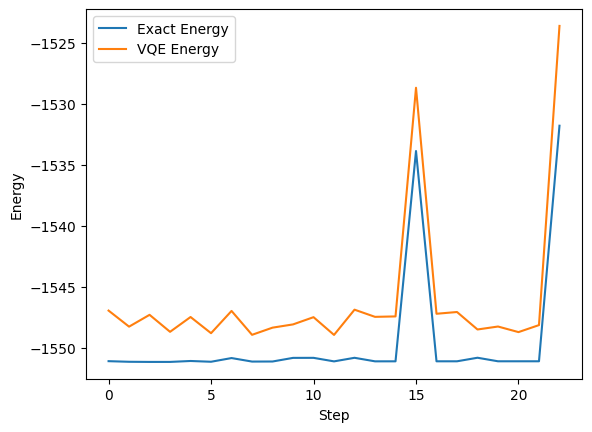

In [38]:

plt.plot(steps, exact_energies, label="Exact Energy")
plt.plot(steps, vqe_energies, label="VQE Energy")
plt.xlabel('Step')
plt.ylabel('Energy')
plt.legend()
plt.show()


In [32]:
# ===
exact_energies = []
vqe_energies = []

steps = range(0,23)
for step in steps:
    print("Starting step:", step, " VQE result:", vqe_energies)
    Fe2_CO2 = get_coord(pth + r'/Fe2_CO2.zip')
    mol, coords = getCoordinate(Fe2_CO2, step, 4)
    print(mol, coords)

    gas_molecules = {
        'Fe2_CO2': {'symbols': mol,
               'coords': coords,
               'multiplicity': 1,
               'charge': 2,
               'units': DistanceUnit.ANGSTROM,
               'masses': [56, 16, 12, 16],
               #'atom_pair': (1, 2), # not available after migration
               'fc_transformer': {
                   'fc_freeze_core': True, 
                   'fc_remove_orbitals': range(13,30),
                   },
    #           'as_transformer': {
    #               'as_num_electrons': 0,
    #               'as_num_spatial_orbitals': 2,
    #               'as_active_orbitals': [1, 1],
    #               }
               }
    }

    hyperparameters = {
        'Fe2_CO2': {'reps': 2,
               'two_qubit_reduction': True,
               'z2symmetry_reduction': None,
               'backend': statevector_simulator #qasm_simulator statevector_simulator
              },

    }


    # ===
    molecule = gas_molecules['Fe2_CO2']
    hyperparam = hyperparameters['Fe2_CO2']
    # display_report = False
    display_dict = {}

    _, energy, display_df = get_construct_problem(input_value = gas_molecules['Fe2_CO2'], hyperparam = hyperparameters['Fe2_CO2'], 
                                                  input_type = 'molecule', display_report = False, reduced = 'FreezeCore', 
                                                  basis = 'sto3g', mapper_type = 'JordanWignerMapper', 
                                                  solver_type = 'numpy_solver', method = 'gses', seed = _SEED)
    #print("Classical:", _, energy, display_df )
    exact_energies.append(energy)

    _, energy, display_df = get_construct_problem(input_value = gas_molecules['Fe2_CO2'], hyperparam = hyperparameters['Fe2_CO2'], 
                                                  input_type = 'molecule', display_report = False, reduced = 'FreezeCore', 
                                                  basis = 'sto3g', mapper_type = 'JordanWignerMapper', 
                                                  solver_type = 'vqe_runtime', method = 'gses', seed = _SEED)
    #print("Quantum mechanic:", _, energy, display_df )
    vqe_energies.append(energy)


Starting step: 0  VQE result: []
['Fe' 'O' 'C' 'O'] [[6.844708500129254, 5.772690500054138, 5.0], [8.228239500226193, 6.352208500094744, 5.0], [9.29272350030078, 6.822059500127666, 5.0], [10.323201500372985, 7.276646500159519, 5.0]]
Starting step: 1  VQE result: [-1431.5485560809748]
['Fe' 'O' 'C' 'O'] [[6.764503782732331, 5.739095260921351, 5.0], [8.30844421762312, 6.385803739227534, 5.0], [9.372928217697705, 6.855654739260454, 5.0], [10.403406217769907, 7.310241739292306, 5.0]]
Starting step: 2  VQE result: [-1431.5485560809748, -1430.343315526808]
['Fe' 'O' 'C' 'O'] [[6.684299065335406, 5.705500021788562, 5.0], [8.388648935020043, 6.419398978360323, 5.0], [9.453132935094628, 6.889249978393244, 5.0], [10.483610935166833, 7.343836978425095, 5.0]]
Starting step: 3  VQE result: [-1431.5485560809748, -1430.343315526808, -1429.6460847797644]
['Fe' 'O' 'C' 'O'] [[6.604094347938481, 5.671904782655773, 5.0], [8.468853652416968, 6.45299421749311, 5.0], [9.533337652491554, 6.922845217526032, 5

['Fe' 'O' 'C' 'O'] [[5.320818869587697, 5.134380956531154, 5.0], [9.75212913076775, 6.99051804361773, 5.0], [10.816613130842336, 7.460369043650651, 5.0], [11.84709113091454, 7.914956043682502, 5.0]]
Starting step: 20  VQE result: [-1431.5485560809748, -1430.343315526808, -1429.6460847797644, -1431.2591171356223, -1430.4453149210167, -1430.967410778262, -1430.7489597890317, -1429.519419751167, -1430.7666854482811, -1430.978316423241, -1429.7132449689514, -1429.396423171862, -1429.8103726998525, -1422.3486589855506, -1417.7436239943397, -1415.9114798943613, -1413.27728266266, -1416.1798824840264, -1390.3802660432889, -1384.4954300498234]
['Fe' 'O' 'C' 'O'] [[5.240614152190773, 5.100785717398365, 5.0], [9.832333848164675, 7.024113282750519, 5.0], [10.89681784823926, 7.49396428278344, 5.0], [11.927295848311466, 7.948551282815292, 5.0]]
Starting step: 21  VQE result: [-1431.5485560809748, -1430.343315526808, -1429.6460847797644, -1431.2591171356223, -1430.4453149210167, -1430.967410778262, 

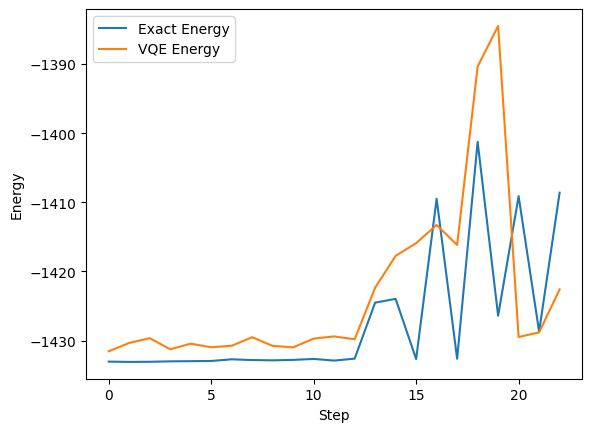

In [33]:

plt.plot(steps, exact_energies, label="Exact Energy")
plt.plot(steps, vqe_energies, label="VQE Energy")
plt.xlabel('Step')
plt.ylabel('Energy')
plt.legend()
plt.show()


In [35]:
# ===
exact_energies = []
vqe_energies = []

steps = range(0,23)
for step in steps:
    print("Starting step:", step, " VQE result:", vqe_energies)
    Cu2_CO2 = get_coord(pth + r'/Cu2_CO2.zip')
    mol, coords = getCoordinate(Cu2_CO2, step, 4)
    print(mol, coords)

    gas_molecules = {
        'Cu2_CO2': {'symbols': mol,
               'coords': coords,
               'multiplicity': 1,
               'charge': 1,
               'units': DistanceUnit.ANGSTROM,
               'masses': [64, 16, 12, 16],
               #'atom_pair': (1, 2), # not available after migration
               'fc_transformer': {
                   'fc_freeze_core': True, 
                   'fc_remove_orbitals': range(13,30),
                   },
    #           'as_transformer': {
    #               'as_num_electrons': 0,
    #               'as_num_spatial_orbitals': 2,
    #               'as_active_orbitals': [1, 1],
    #               }
               }
    }

    hyperparameters = {
        'Cu2_CO2': {'reps': 2,
               'two_qubit_reduction': True,
               'z2symmetry_reduction': None,
               'backend': qasm_simulator #qasm_simulator
              },

    }


    # ===
    molecule = gas_molecules['Cu2_CO2']
    hyperparam = hyperparameters['Cu2_CO2']
    # display_report = False
    display_dict = {}

    _, energy, display_df = get_construct_problem(input_value = gas_molecules['Cu2_CO2'], hyperparam = hyperparameters['Cu2_CO2'], 
                                                  input_type = 'molecule', display_report = False, reduced = 'FreezeCore', 
                                                  basis = 'sto3g', mapper_type = 'JordanWignerMapper', 
                                                  solver_type = 'numpy_solver', method = 'gses', seed = _SEED)
    #print("Classical:", _, energy, display_df )
    exact_energies.append(energy)

    _, energy, display_df = get_construct_problem(input_value = gas_molecules['Cu2_CO2'], hyperparam = hyperparameters['Cu2_CO2'], 
                                                  input_type = 'molecule', display_report = False, reduced = 'FreezeCore', 
                                                  basis = 'sto3g', mapper_type = 'JordanWignerMapper', 
                                                  solver_type = 'vqe_runtime', method = 'gses', seed = _SEED)
    #print("Quantum mechanic:", _, energy, display_df )
    vqe_energies.append(energy)


Starting step: 0  VQE result: []
['Cu' 'O' 'C' 'O'] [[6.844708500129254, 5.772690500054138, 5.0], [8.228239500226193, 6.352208500094744, 5.0], [9.29272350030078, 6.822059500127666, 5.0], [10.323201500372985, 7.276646500159519, 5.0]]
Starting step: 1  VQE result: [-1802.4078188977248]
['Cu' 'O' 'C' 'O'] [[6.764503782732331, 5.739095260921351, 5.0], [8.30844421762312, 6.385803739227534, 5.0], [9.372928217697705, 6.855654739260454, 5.0], [10.403406217769907, 7.310241739292306, 5.0]]
Starting step: 2  VQE result: [-1802.4078188977248, -1802.871748625943]
['Cu' 'O' 'C' 'O'] [[6.684299065335406, 5.705500021788562, 5.0], [8.388648935020043, 6.419398978360323, 5.0], [9.453132935094628, 6.889249978393244, 5.0], [10.483610935166833, 7.343836978425095, 5.0]]
Starting step: 3  VQE result: [-1802.4078188977248, -1802.871748625943, -1801.5149214533938]
['Cu' 'O' 'C' 'O'] [[6.604094347938481, 5.671904782655773, 5.0], [8.468853652416968, 6.45299421749311, 5.0], [9.533337652491554, 6.922845217526032, 5

['Cu' 'O' 'C' 'O'] [[5.320818869587697, 5.134380956531154, 5.0], [9.75212913076775, 6.99051804361773, 5.0], [10.816613130842336, 7.460369043650651, 5.0], [11.84709113091454, 7.914956043682502, 5.0]]
Starting step: 20  VQE result: [-1802.4078188977248, -1802.871748625943, -1801.5149214533938, -1802.126599006941, -1802.7754554519338, -1802.4707381574015, -1802.6550642250165, -1802.8518056811813, -1801.5583409692317, -1802.7038170049414, -1801.6060507263326, -1802.1137998867075, -1802.3716580355217, -1802.4294644332538, -1801.2619102886717, -1801.3634363170677, -1801.3067203734156, -1802.1563082140592, -1802.2367389954209, -1792.7171893000514]
['Cu' 'O' 'C' 'O'] [[5.240614152190773, 5.100785717398365, 5.0], [9.832333848164675, 7.024113282750519, 5.0], [10.89681784823926, 7.49396428278344, 5.0], [11.927295848311466, 7.948551282815292, 5.0]]
Starting step: 21  VQE result: [-1802.4078188977248, -1802.871748625943, -1801.5149214533938, -1802.126599006941, -1802.7754554519338, -1802.4707381574

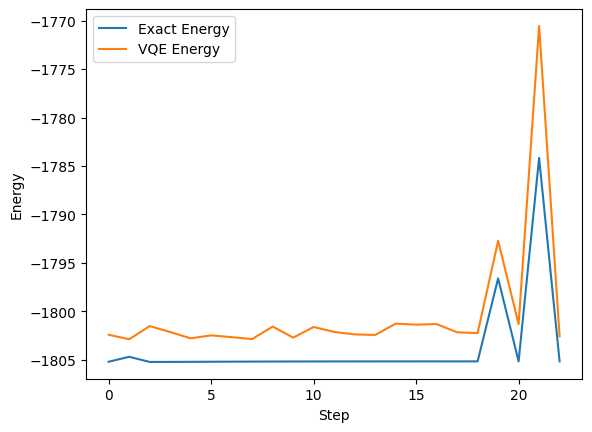

In [36]:

plt.plot(steps, exact_energies, label="Exact Energy")
plt.plot(steps, vqe_energies, label="VQE Energy")
plt.xlabel('Step')
plt.ylabel('Energy')
plt.legend()
plt.show()
